In [1]:
import sys
import os

repo_root = os.path.abspath(os.path.join(os.path.dirname(os.getcwd())))
sys.path.append(repo_root)

print(repo_root)

/home/jackyeung99/classes/class_financial-econometrics


In [2]:
import matplotlib.pyplot as plt
import math 
import numpy as np
import pandas as pd
from pandas_datareader import data as pdr
from statsmodels.tsa.stattools import adfuller, coint
from statsmodels.tsa.arima.model import ARIMA

In [3]:
plt.style.use("../styler.mplstyle") 

In [22]:
data = ['CPIAUCSL', 'GDPC1', 'CNP16OV', 'FEDFUNDS', 'LRUN64MAUSM156S', 'LRUN64FEUSM156S']

In [23]:
df = pdr.DataReader(
    data,
    "fred",
    start="1980-01-01",
    end="2025-07-01"
).astype(float).reset_index()

In [24]:
df['INF'] = 400 * np.log(df['CPIAUCSL']/ df['CPIAUCSL'].shift(-1))
df['INF_demeaned'] = df['INF'] - df['INF'].mean()

### Question 1

Text(0, 0.5, '$\\Delta$ INF')

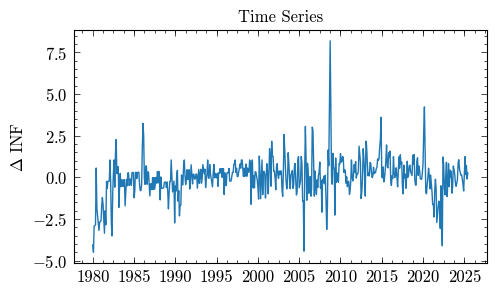

In [7]:
plt.plot(df['DATE'], df['INF_demeaned'])
plt.title("Time Series")
# plt.xlabel("Time")
plt.ylabel("$\Delta$ INF")


In [8]:
p_vals = [0, 1, 2, 3]
q_vals = [0, 1, 2, 3]

In [9]:
models = {}
model_summaries = []

In [10]:
for p in p_vals:  
    for q in q_vals:

        if p == q and p == 0:
            continue
        

        model = ARIMA(df['INF_demeaned'], order=(p, 0, q))
        model_fit = model.fit()

        model_summaries.append({
            'p' : p, 
            'q': q,
            'AIC': model_fit.aic,
            'BIC': model_fit.bic,
            'log_like': model_fit.llf
        })
        models[f'{p}{q}'] = model_fit
        
    

        

/home/jackyeung99/classes/class_financial-econometrics/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/jackyeung99/classes/class_financial-econometrics/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/jackyeung99/classes/class_financial-econometrics/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


In [11]:
pd.DataFrame(model_summaries)

,p,q,AIC,BIC,log_like
0,0,1,1542.600586,1555.513932,-768.300293
1,0,2,1527.010672,1544.228467,-759.505336
2,0,3,1526.519965,1548.042209,-758.259982
3,1,0,1525.401504,1538.314850,-759.700752
4,1,1,1521.290316,1538.508112,-756.645158
5,1,2,1497.381656,1518.903900,-743.690828
6,1,3,1498.163687,1523.990379,-743.081843
7,2,0,1523.986330,1541.204126,-757.993165
8,2,1,1521.285486,1542.807730,-755.642743
9,2,2,1498.370430,1524.197123,-743.185215


In [12]:
summary_df = pd.DataFrame(model_summaries).sort_values('AIC').reset_index(drop=True)
topN = 2 
top_rows = summary_df.head(topN)
top_rows[['p', 'q', 'AIC']]

,p,q,AIC
0,1,2,1497.381656
1,1,3,1498.163687


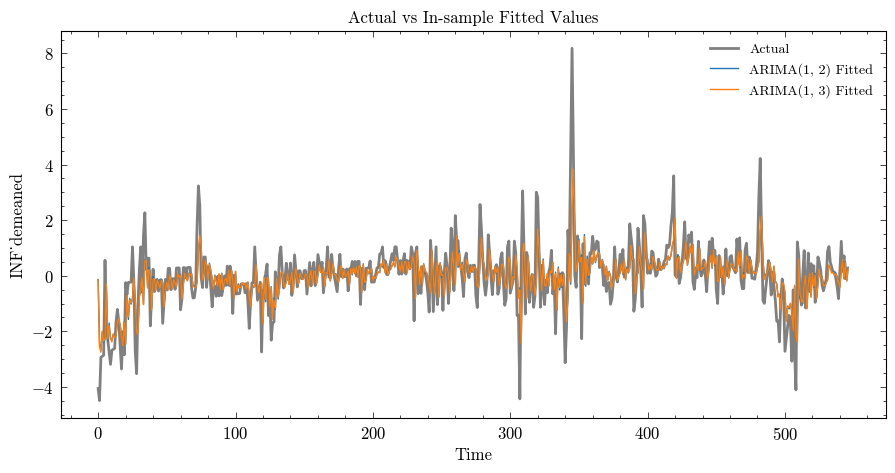

In [13]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(df.index, df['INF_demeaned'], label='Actual', linewidth=2, color='grey')

for i, (_, row) in enumerate(top_rows.iterrows()):
    p = int(row['p'])
    q = int(row['q'])
    
    model_fit = models[f'{p}{q}']  
    ax.plot(
        model_fit.fittedvalues,
        label=f'ARIMA({p}, {q}) Fitted',
        # color=colors[i]
    )

# Format the plot
ax.set_title('Actual vs In-sample Fitted Values')
ax.set_xlabel('Time')
ax.set_ylabel('INF_demeaned')
ax.legend()

plt.savefig('../Figures/Assignment06/aic.png', dpi = 300)
plt.show()

In [20]:
summary_df = pd.DataFrame(model_summaries).sort_values('BIC').reset_index(drop=True)

topN = 2 
top_rows = summary_df.head(topN)
top_rows[['p', 'q', 'BIC']]

,p,q,BIC
0,1,2,1518.903900
1,1,3,1523.990379


In [19]:
summary_df

,p,q,AIC,BIC,log_like
0,1,2,1497.381656,1518.903900,-743.690828
1,1,3,1498.163687,1523.990379,-743.081843
2,2,2,1498.370430,1524.197123,-743.185215
3,3,1,1498.402219,1524.228911,-743.201109
4,3,2,1499.532644,1529.663786,-742.766322
5,2,3,1499.582085,1529.713227,-742.791043
6,3,0,1513.408271,1534.930515,-751.704136
7,3,3,1501.318085,1535.753676,-742.659043
8,1,0,1525.401504,1538.314850,-759.700752
9,1,1,1521.290316,1538.508112,-756.645158


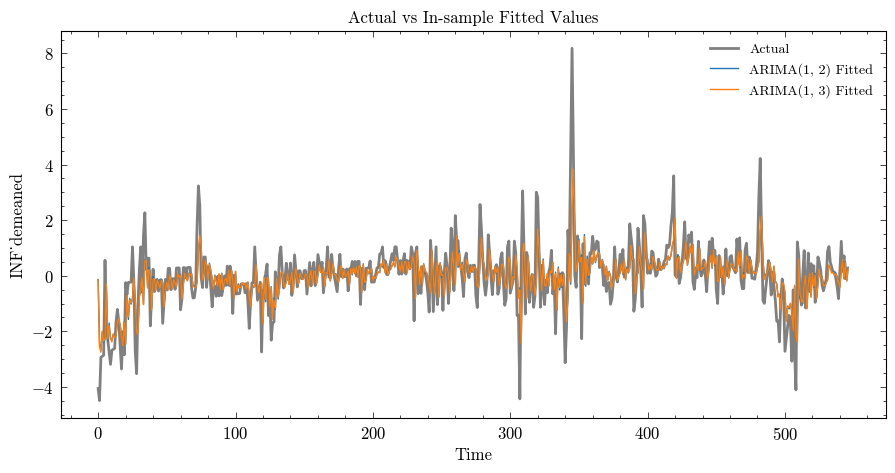

In [15]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(df.index, df['INF_demeaned'], label='Actual', linewidth=2, color='grey')

for i, (_, row) in enumerate(top_rows.iterrows()):
    p = int(row['p'])
    q = int(row['q'])
    
    model_fit = models[f'{p}{q}']  
    ax.plot(
        model_fit.fittedvalues,
        label=f'ARIMA({p}, {q}) Fitted',
        # color=colors[i]
    )

# Format the plot
ax.set_title('Actual vs In-sample Fitted Values')
ax.set_xlabel('Time')
ax.set_ylabel('INF_demeaned')
ax.legend()

plt.savefig('../Figures/Assignment06/bic.png', dpi = 300)
plt.show()

### Question 2